### Setup and Load Data

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score
from transformers import AutoTokenizer, AutoModelForCausalLM
from modelscope import snapshot_download

# Custom module imports
from config import DATA_LIMIT, get_feature_path, get_checkpoint_path, HIDDEN_DIM, MODEL_ID, CACHE_DIR
from core import FFLayerProbe
from train_probe import calculate_ff_auroc

# Configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TARGET_LAYER = 25

# Load all features ONCE to avoid repeated I/O
print("📥 Loading features...")
sqa_feat_path = get_feature_path("simpleqa")
lqa_feat_path = get_feature_path("logiqa")

sqa_data = torch.load(sqa_feat_path, map_location=DEVICE, weights_only=True)
sqa_pos = sqa_data["pos"].to(DEVICE)
sqa_neg = sqa_data["neg"].to(DEVICE)

lqa_data = torch.load(lqa_feat_path, map_location=DEVICE, weights_only=True)
lqa_pos = lqa_data["pos"].to(DEVICE)
lqa_neg = lqa_data["neg"].to(DEVICE)

print(f"✅ SimpleQA Shape: {sqa_pos.shape}")
print(f"✅ LogiQA Shape: {lqa_pos.shape}")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📥 Loading features...
✅ SimpleQA Shape: torch.Size([400, 33, 4096])
✅ LogiQA Shape: torch.Size([200, 33, 4096])


In [2]:
print("🚀 Loading Model...")
model_dir = snapshot_download(
    MODEL_ID, 
    cache_dir=CACHE_DIR, 
    revision='master',
    ignore_patterns=["*.gguf", "*.pth", "*.pt", "original/*"] 
)

tokenizer = AutoTokenizer.from_pretrained(model_dir)
if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    torch_dtype=torch.bfloat16, 
    device_map="auto", 
    trust_remote_code=True
)
model.eval()
print("✅ Model loaded successfully!")

🚀 Loading Model...


2026-02-25 21:33:29,685 - modelscope - INFO - Target directory already exists, skipping creation.
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.21s/it]

✅ Model loaded successfully!


### Run All Models (Fast Mode)

In [3]:
import torch
import numpy as np
from tqdm import tqdm
from utils.baselines import calculate_prob_entropy_auroc
from utils import prepare_simpleqa_data

def get_generation_probabilities(model, tokenizer, dataset):
    """Calculates the mean log probability of the generated target for Probability Baseline."""
    pos_probs = []
    neg_probs = []
    
    # Ensure pad token is set
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
        
    model.eval()
    with torch.no_grad():
        for item in tqdm(dataset, desc="Calculating Probability Baseline"):
            # Compute for Positive Target
            pos_text = f"Question: {item['user_content']}\nAnswer: {item['pos_target']}"
            pos_inputs = tokenizer(pos_text, return_tensors="pt").to(model.device)
            pos_outputs = model(**pos_inputs, labels=pos_inputs["input_ids"], use_cache=False)
            # Neg-log-likelihood is the loss, we convert it to probability score (-loss = log prob)
            pos_probs.append(-pos_outputs.loss.item())
            
            # Compute for Negative Target
            neg_text = f"Question: {item['user_content']}\nAnswer: {item['neg_target']}"
            neg_inputs = tokenizer(neg_text, return_tensors="pt").to(model.device)
            neg_outputs = model(**neg_inputs, labels=neg_inputs["input_ids"], use_cache=False)
            neg_probs.append(-neg_outputs.loss.item())
            
    return pos_probs, neg_probs

print("🚀 Extracting Probabilities for Entropy Baseline...")
simpleqa_data = prepare_simpleqa_data(model, tokenizer, limit=200)
pos_probs, neg_probs = get_generation_probabilities(model, tokenizer, simpleqa_data)
prob_baseline_auroc = calculate_prob_entropy_auroc(pos_probs, neg_probs)
print(f"✅ Probability Baseline AUROC: {prob_baseline_auroc:.4f}")

🚀 Extracting Probabilities for Entropy Baseline...

🚀 Loading SimpleQA (Target: 200 samples)...


Generating train split: 1000 examples [00:00, 83706.95 examples/s]
Mining SimpleQA:  30%|████████████████████████████████████████████████████▊                                                                                                                          | 19/63 [01:12<02:47,  3.80s/it]


✅ Extracted 200 SimpleQA samples.
📊 Stats - Errors kept: 200, Correct skipped: 6, Refusals: 95


Calculating Probability Baseline: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.23it/s]

✅ Probability Baseline AUROC: 0.6943



🚀 1/5 Loading Ours (FF Probe + PeerNorm)...

🚀 2/5 Adding Probability/Entropy Baseline...

🚀 3/5 Training Baseline (CCS)...


CCS Baseline Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  4.84it/s]



🚀 4/5 Calculating Baseline (Logistic Regression & Mass-Mean)...

Training LR Baseline...
Calculating Mass-Mean Baseline...
🚀 5/5 Training Baseline (Standard MLP)...


MLP Baseline Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:45<00:00,  1.36s/it]



✅ All Baselines Evaluated!


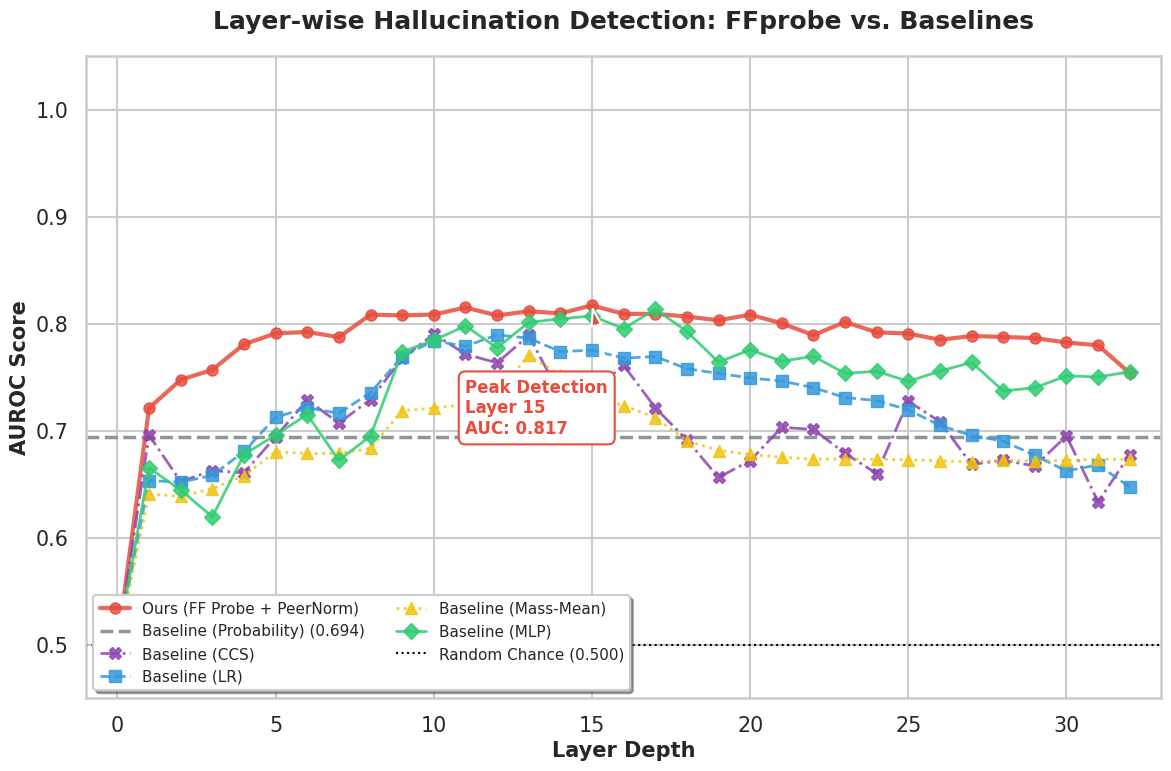


🔬 Benchmark Comparison Table (Evaluated at Peak Layer)
| Method                     | Best Layer   |   SimpleQA (ID) AUROC |
|----------------------------|--------------|-----------------------|
| Ours (FF Probe + PeerNorm) | 15           |                0.8172 |
| Baseline (MLP)             | 17           |                0.8137 |
| Baseline (CCS)             | 10           |                0.7903 |
| Baseline (LR)              | 12           |                0.7896 |
| Baseline (Mass-Mean)       | 13           |                0.7704 |
| Baseline (Probability)     | N/A (Output) |                0.6943 |



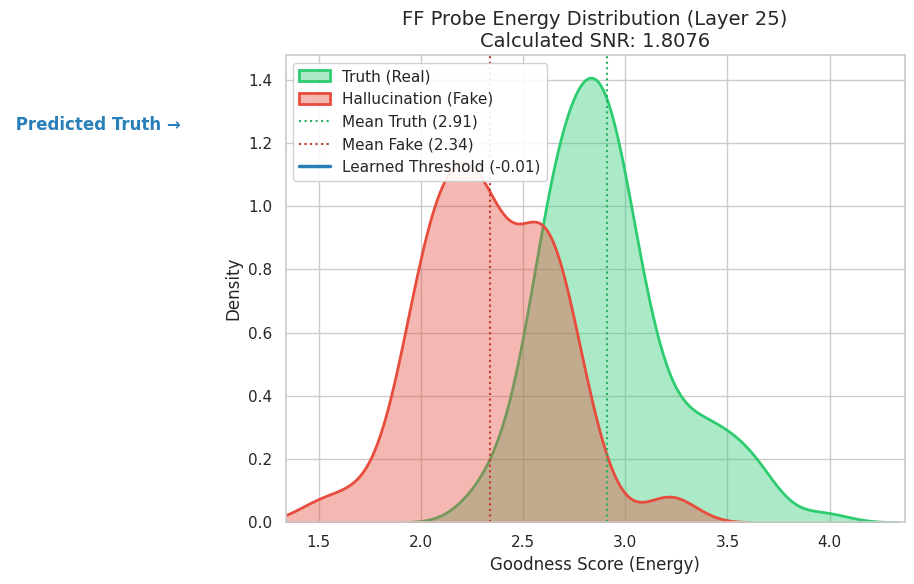

In [4]:
import torch
import numpy as np
from core import FFLayerProbe
from utils import (
    calculate_lr_auroc, 
    calculate_mass_mean_auroc, 
    calculate_mlp_auroc,
    calculate_ccs_auroc,
    plot_auroc_comparison,
    plot_snr_distribution,
    generate_academic_baseline_table
)

results_dict = {}

# 1. Load Pre-trained FF Probe
print("\n🚀 1/5 Loading Ours (FF Probe + PeerNorm)...")
metrics_path = get_checkpoint_path("metrics")
weights_path = get_checkpoint_path("weights")
metrics = torch.load(metrics_path)
ff_weights = torch.load(weights_path)

results_dict['Ours (FF Probe + PeerNorm)'] = metrics['FF_SimpleQA_Mean']

# 2. Add Probability Baseline (from Cell 1)
print("\n🚀 2/5 Adding Probability/Entropy Baseline...")
# Duplicate the single score across all layers so it draws as a straight horizontal line
n_layers = sqa_pos.shape[1]
results_dict['Baseline (Probability)'] = [prob_baseline_auroc] * n_layers

# 3. CCS Baseline (New!)
print("\n🚀 3/5 Training Baseline (CCS)...")
results_dict['Baseline (CCS)'] = calculate_ccs_auroc(sqa_pos, sqa_neg, device=DEVICE)

# 4. Standard Linear Baselines
print("\n🚀 4/5 Calculating Baseline (Logistic Regression & Mass-Mean)...")
results_dict['Baseline (LR)'] = calculate_lr_auroc(sqa_pos, sqa_neg)
results_dict['Baseline (Mass-Mean)'] = calculate_mass_mean_auroc(sqa_pos, sqa_neg)

# 5. Global MLP Baseline
print("\n🚀 5/5 Training Baseline (Standard MLP)...")
results_dict['Baseline (MLP)'] = calculate_mlp_auroc(sqa_pos, sqa_neg, n_epochs=50, device=DEVICE)

print("\n✅ All Baselines Evaluated!")

# Plot AUROC comparisons
plot_auroc_comparison(results_dict)
benchmark_df = generate_academic_baseline_table(results_dict)

# Calculate SNR for target layer using loaded weights
TARGET_LAYER = 25
best_model_info = ff_weights[TARGET_LAYER]
probe = FFLayerProbe(in_dim=sqa_pos.shape[-1], hidden_dim=HIDDEN_DIM, device=DEVICE)
probe.load_state_dict(best_model_info['state_dict'])
probe.eval()

split_idx = int(sqa_pos.shape[0] * 0.7) # get test set
with torch.no_grad():
    sp = probe(sqa_pos[split_idx:, TARGET_LAYER, :].to(DEVICE)).cpu().numpy()
    sn = probe(sqa_neg[split_idx:, TARGET_LAYER, :].to(DEVICE)).cpu().numpy()

plot_snr_distribution(sp, sn, layer_idx=TARGET_LAYER, learned_threshold=best_model_info['threshold'])

🚀 Starting Ablation Study: PeerNorm Impact Across Layers...

Training Ablation: Without PeerNorm...


Ablation (No PeerNorm) Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.07it/s]


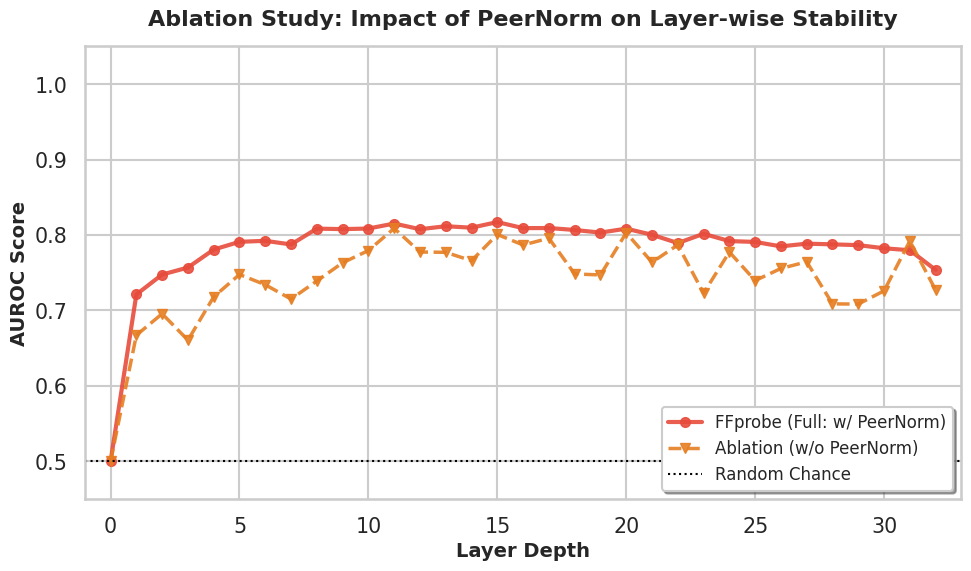

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.baselines import calculate_ff_no_peernorm_auroc

print("🚀 Starting Ablation Study: PeerNorm Impact Across Layers...")

print("\nTraining Ablation: Without PeerNorm...")
no_peernorm_aurocs = calculate_ff_no_peernorm_auroc(sqa_pos, sqa_neg, n_epochs=50, device=DEVICE)

full_aurocs = results_dict['Ours (FF Probe + PeerNorm)']

sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)
fig, ax = plt.subplots(figsize=(10, 6))
layers = np.arange(len(full_aurocs))


ax.plot(layers, full_aurocs, label='FFprobe (Full: w/ PeerNorm)', 
        color='#E74C3C', linewidth=3.0, linestyle='-', marker='o', markersize=7, alpha=0.9)

ax.plot(layers, no_peernorm_aurocs, label='Ablation (w/o PeerNorm)', 
        color='#E67E22', linewidth=2.5, linestyle='--', marker='v', markersize=7, alpha=0.9)
ax.axhline(0.5, color='black', linestyle=':', linewidth=1.5, label='Random Chance')
ax.set_title("Ablation Study: Impact of PeerNorm on Layer-wise Stability", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Layer Depth", fontsize=14, fontweight='bold')
ax.set_ylabel("AUROC Score", fontsize=14, fontweight='bold')

# Dynamic y-axis to fit data properly
y_min = min(min(full_aurocs), min(no_peernorm_aurocs)) - 0.05
ax.set_ylim(max(0.4, y_min), 1.05)
ax.set_xlim(-1, len(layers))

ax.legend(loc='lower right', frameon=True, fontsize=12, fancybox=True, shadow=True)

fig.tight_layout()
plt.show()

### Cognitive Orthogonality

🚀 Training Probe for SimpleQA (Facts)...


FF Probe Training:   3%|█████▎                                                                                                                                                                        | 1/33 [00:01<01:00,  1.88s/it]

  Layer 0: AUC=0.5000±0.0000 (θ=0.03)


FF Probe Training:  18%|███████████████████████████████▋                                                                                                                                              | 6/33 [00:11<00:50,  1.88s/it]

  Layer 5: AUC=0.7723±0.0170 (θ=0.00)


FF Probe Training:  33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 11/33 [00:20<00:41,  1.89s/it]

  Layer 10: AUC=0.8126±0.0015 (θ=-0.01)


FF Probe Training:  48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 16/33 [00:30<00:32,  1.94s/it]

  Layer 15: AUC=0.7980±0.0138 (θ=0.00)


FF Probe Training:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 21/33 [00:39<00:22,  1.90s/it]

  Layer 20: AUC=0.7905±0.0256 (θ=-0.01)


FF Probe Training:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 26/33 [00:49<00:13,  1.89s/it]

  Layer 25: AUC=0.8021±0.0296 (θ=-0.01)


FF Probe Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 31/33 [00:58<00:03,  1.88s/it]

  Layer 30: AUC=0.7668±0.0042 (θ=-0.01)


FF Probe Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [01:02<00:00,  1.89s/it]


🚀 Training Probe for LogiQA (Logic)...


FF Probe Training:   3%|█████▎                                                                                                                                                                        | 1/33 [00:01<00:38,  1.21s/it]

  Layer 0: AUC=0.5000±0.0000 (θ=0.03)


FF Probe Training:  18%|███████████████████████████████▋                                                                                                                                              | 6/33 [00:07<00:32,  1.19s/it]

  Layer 5: AUC=0.5451±0.0436 (θ=0.01)


FF Probe Training:  33%|█████████████████████████████████████████████████████████▋                                                                                                                   | 11/33 [00:13<00:26,  1.18s/it]

  Layer 10: AUC=0.5029±0.0374 (θ=0.00)


FF Probe Training:  48%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 16/33 [00:18<00:19,  1.17s/it]

  Layer 15: AUC=0.5858±0.0200 (θ=0.00)


FF Probe Training:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 21/33 [00:24<00:14,  1.19s/it]

  Layer 20: AUC=0.5934±0.0175 (θ=-0.02)


FF Probe Training:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 26/33 [00:30<00:08,  1.20s/it]

  Layer 25: AUC=0.5731±0.0094 (θ=-0.01)


FF Probe Training:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 31/33 [00:36<00:02,  1.18s/it]

  Layer 30: AUC=0.6258±0.0417 (θ=-0.01)


FF Probe Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:39<00:00,  1.19s/it]


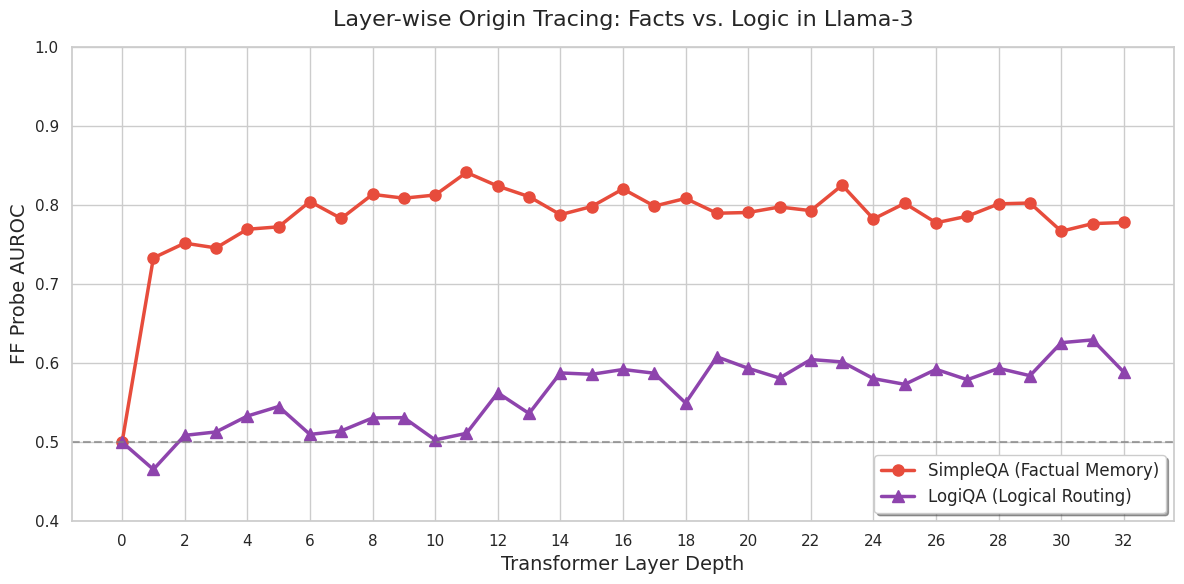

✅ Models successfully saved to `sqa_models` and `lqa_models`!


In [6]:
def run_origin_tracing_experiment(sqa_pos, sqa_neg, lqa_pos, lqa_neg):
    print("🚀 Training Probe for SimpleQA (Facts)...")
    sqa_aucs, sqa_models = calculate_ff_auroc(sqa_pos, sqa_neg, n_epochs=50)
    
    print("🚀 Training Probe for LogiQA (Logic)...")
    lqa_aucs, lqa_models = calculate_ff_auroc(lqa_pos, lqa_neg, n_epochs=50)
    
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    
    layers = list(range(len(sqa_aucs)))
    plt.plot(layers, sqa_aucs, marker='o', color='#E74C3C', linewidth=2.5, markersize=8, label='SimpleQA (Factual Memory)')
    plt.plot(layers, lqa_aucs, marker='^', color='#8E44AD', linewidth=2.5, markersize=8, label='LogiQA (Logical Routing)')
    
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.title('Layer-wise Origin Tracing: Facts vs. Logic in Llama-3', fontsize=16, pad=15)
    plt.xlabel('Transformer Layer Depth', fontsize=14)
    plt.ylabel('FF Probe AUROC', fontsize=14)
    plt.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
    plt.ylim(0.4, 1.0)
    plt.xticks(range(0, len(layers), 2))
    
    plt.tight_layout()
    plt.show()
    return sqa_models, lqa_models

sqa_models, lqa_models = run_origin_tracing_experiment(sqa_pos, sqa_neg, lqa_pos, lqa_neg)
print("✅ Models successfully saved to `sqa_models` and `lqa_models`!")

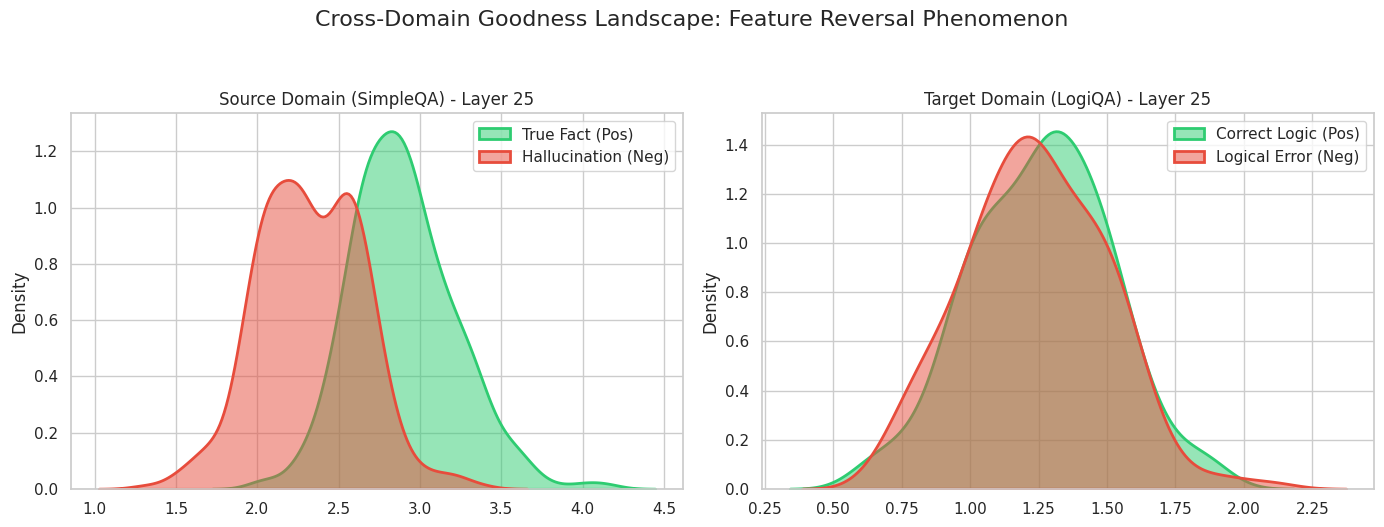

🚀 Training Dedicated Logic Probe for Layer 25...


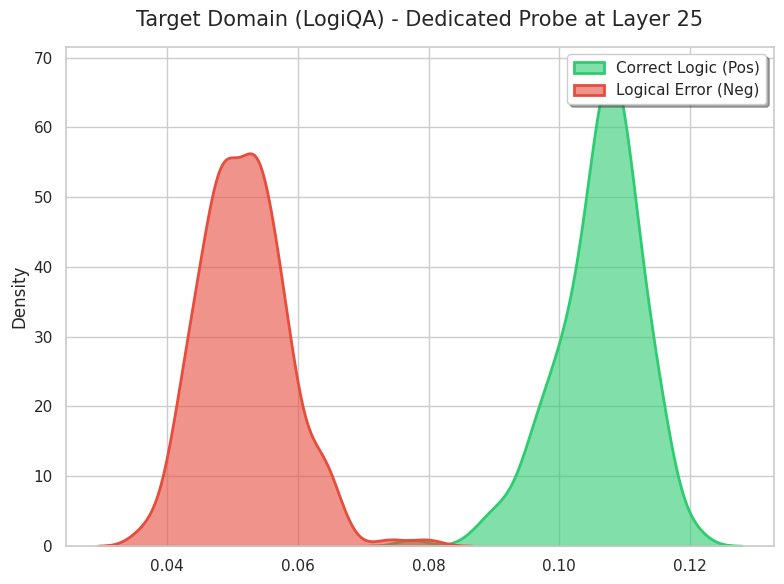

In [7]:
def plot_energy_landscape(probe, sqa_pos, sqa_neg, lqa_pos, lqa_neg, target_layer):
    probe.eval()
    with torch.no_grad():
        g_sqa_pos = probe(sqa_pos[:, target_layer, :]).cpu().numpy()
        g_sqa_neg = probe(sqa_neg[:, target_layer, :]).cpu().numpy()
        g_lqa_pos = probe(lqa_pos[:, target_layer, :]).cpu().numpy()
        g_lqa_neg = probe(lqa_neg[:, target_layer, :]).cpu().numpy()

    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.kdeplot(g_sqa_pos, fill=True, color='#2ECC71', alpha=0.5, linewidth=2, label='True Fact (Pos)', ax=axes[0])
    sns.kdeplot(g_sqa_neg, fill=True, color='#E74C3C', alpha=0.5, linewidth=2, label='Hallucination (Neg)', ax=axes[0])
    axes[0].set_title(f'Source Domain (SimpleQA) - Layer {target_layer}')
    axes[0].legend(loc='upper right', frameon=True)

    sns.kdeplot(g_lqa_pos, fill=True, color='#2ECC71', alpha=0.5, linewidth=2, label='Correct Logic (Pos)', ax=axes[1])
    sns.kdeplot(g_lqa_neg, fill=True, color='#E74C3C', alpha=0.5, linewidth=2, label='Logical Error (Neg)', ax=axes[1])
    axes[1].set_title(f'Target Domain (LogiQA) - Layer {target_layer}')
    axes[1].legend(loc='upper right', frameon=True)

    plt.suptitle('Cross-Domain Goodness Landscape: Feature Reversal Phenomenon', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

def plot_independent_logiqa_landscape(lqa_pos, lqa_neg, target_layer):
    print(f"🚀 Training Dedicated Logic Probe for Layer {target_layer}...")
    logic_probe = FFLayerProbe(in_dim=lqa_pos.shape[2]).to(DEVICE)
    
    Xp, Xn = lqa_pos[:, target_layer, :], lqa_neg[:, target_layer, :]
    for _ in range(150):
        logic_probe.train_step(Xp, Xn)
        
    logic_probe.eval()
    with torch.no_grad():
        g_lqa_pos = logic_probe(Xp).cpu().numpy()
        g_lqa_neg = logic_probe(Xn).cpu().numpy()

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.kdeplot(g_lqa_pos, fill=True, color='#2ECC71', alpha=0.6, linewidth=2, label='Correct Logic (Pos)')
    sns.kdeplot(g_lqa_neg, fill=True, color='#E74C3C', alpha=0.6, linewidth=2, label='Logical Error (Neg)')
    
    plt.title(f'Target Domain (LogiQA) - Dedicated Probe at Layer {target_layer}', fontsize=15, pad=15)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()

# Extract the probe trained purely on SimpleQA from earlier
best_model_info = ff_weights[TARGET_LAYER]
input_dim = sqa_pos.shape[-1]
sqa_probe = FFLayerProbe(in_dim=input_dim, hidden_dim=HIDDEN_DIM, device=DEVICE).to(DEVICE)
sqa_probe.load_state_dict(best_model_info['state_dict'])
sqa_probe.eval()

plot_energy_landscape(sqa_probe, sqa_pos, sqa_neg, lqa_pos, lqa_neg, TARGET_LAYER)
plot_independent_logiqa_landscape(lqa_pos, lqa_neg, TARGET_LAYER)

🚀 Analyzing Probe Weights for Dimensional Orthogonality...
📊 Top-50 Neuron Overlap between Facts and Logic: 2.0%


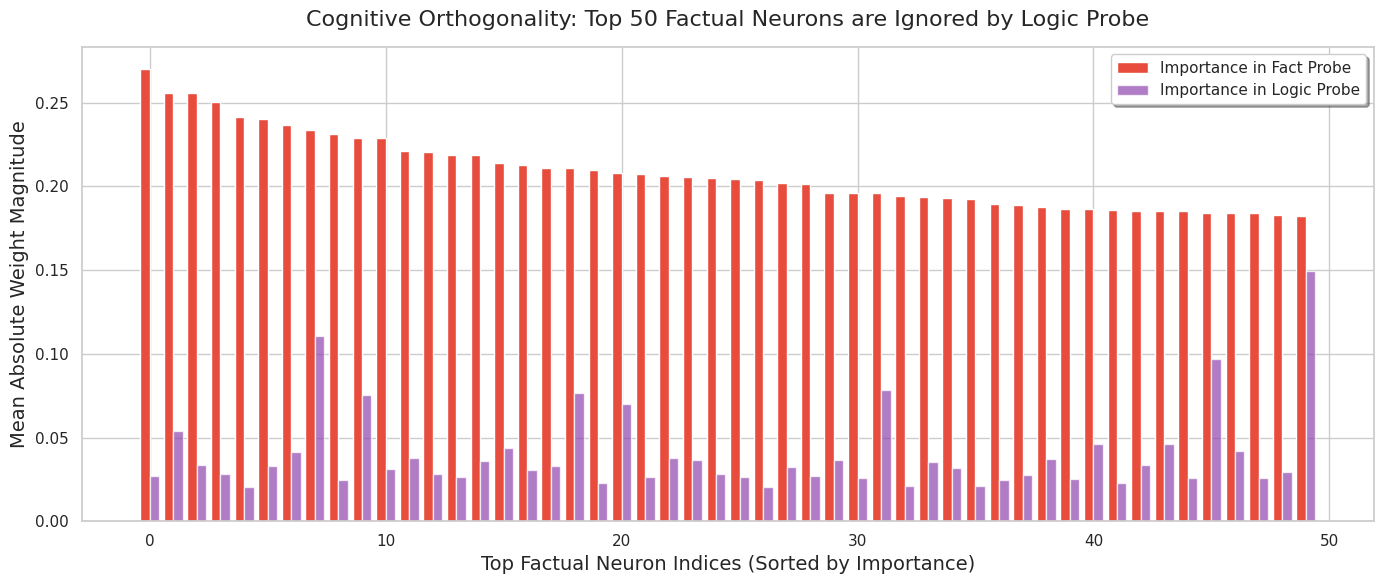

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_neuron_attribution(sqa_probe, lqa_probe, top_k=50):
    print("🚀 Analyzing Probe Weights for Dimensional Orthogonality...")
    
    # FIX: Average the absolute weights across the hidden dimension (dim=0) 
    # to get a 1D importance score for each input neuron.
    sqa_weights = sqa_probe.linear.weight.detach().cpu().abs().mean(dim=0)
    lqa_weights = lqa_probe.linear.weight.detach().cpu().abs().mean(dim=0)
    
    # Now these are 1D tensors
    sqa_top_indices = torch.argsort(sqa_weights, descending=True)[:top_k]
    lqa_top_indices = torch.argsort(lqa_weights, descending=True)[:top_k]
    
    # FIX: Convert 1D tensors to standard Python lists before turning into sets
    sqa_set = set(sqa_top_indices.tolist())
    lqa_set = set(lqa_top_indices.tolist())
    
    overlap_ratio = len(sqa_set.intersection(lqa_set)) / top_k
    print(f"📊 Top-{top_k} Neuron Overlap between Facts and Logic: {overlap_ratio*100:.1f}%")
    
    # Visualization data
    sqa_vals_in_sqa = sqa_weights[sqa_top_indices].numpy()
    sqa_vals_in_lqa = lqa_weights[sqa_top_indices].numpy()
    
    plt.figure(figsize=(14, 6))
    x = np.arange(top_k)
    width = 0.4
    
    plt.bar(x - width/2, sqa_vals_in_sqa, width, label='Importance in Fact Probe', color='#E74C3C')
    plt.bar(x + width/2, sqa_vals_in_lqa, width, label='Importance in Logic Probe', color='#8E44AD', alpha=0.7)
    
    plt.title(f'Cognitive Orthogonality: Top {top_k} Factual Neurons are Ignored by Logic Probe', fontsize=16, pad=15)
    plt.xlabel('Top Factual Neuron Indices (Sorted by Importance)', fontsize=14)
    plt.ylabel('Mean Absolute Weight Magnitude', fontsize=14)
    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()

# --- Setup probes using explicitly saved models ---
TARGET_LAYER = 25
input_dim = sqa_pos.shape[2]

sqa_probe = FFLayerProbe(in_dim=input_dim, hidden_dim=HIDDEN_DIM, device=DEVICE).to(DEVICE)
sqa_probe.load_state_dict(sqa_models[TARGET_LAYER]['state_dict'])

lqa_probe = FFLayerProbe(in_dim=input_dim, hidden_dim=HIDDEN_DIM, device=DEVICE).to(DEVICE)
lqa_probe.load_state_dict(lqa_models[TARGET_LAYER]['state_dict'])

plot_neuron_attribution(sqa_probe, lqa_probe, top_k=50)

### Surgical Continual Learning

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from utils import( 
    FFLayerProbeNoZScore,
    FFLayerProbeNoPeerNorm,
    StandardMLP
)

def compute_auc_generic(model, pos_feat, neg_feat, is_mlp=False):
    model.eval()
    with torch.no_grad():
        if is_mlp:
            p = model(pos_feat).cpu().numpy()
            n = model(neg_feat).cpu().numpy()
        else:
            p = model(pos_feat).cpu().numpy()
            n = model(neg_feat).cpu().numpy()
            
    y_true = [1] * len(p) + [0] * len(n)
    return roc_auc_score(y_true, list(p) + list(n))

def run_robust_continual_learning(sqa_pos, sqa_neg, lqa_pos, lqa_neg, target_layer=30, n_seeds=3):
    print(f"🚀 Running Continual Learning across {n_seeds} seeds at Layer {target_layer}...")
    input_dim = sqa_pos.shape[-1]
    device = sqa_pos.device
    
    results = []
    
    for seed in range(n_seeds):
        print(f"\n--- Seed {seed + 1}/{n_seeds} ---")
        torch.manual_seed(42 + seed)
        np.random.seed(42 + seed)
        
        # 1. Data Shuffling & Splitting
        sqa_idx = torch.randperm(sqa_pos.shape[0])
        lqa_idx = torch.randperm(lqa_pos.shape[0])
        
        sqa_p = sqa_pos[sqa_idx, target_layer, :]
        sqa_n = sqa_neg[sqa_idx, target_layer, :]
        lqa_p = lqa_pos[lqa_idx, target_layer, :]
        lqa_n = lqa_neg[lqa_idx, target_layer, :]
        
        split_idx = int(sqa_p.shape[0] * 0.7)
        sqa_p_tr, sqa_p_te = sqa_p[:split_idx], sqa_p[split_idx:]
        sqa_n_tr, sqa_n_te = sqa_n[:split_idx], sqa_n[split_idx:]
        
        # Setup specific for the surgical fine-tuning (e.g., 150 target domain, 30 replay)
        few_shot_size, replay_size = 150, 30
        lqa_p_few, lqa_p_te = lqa_p[:few_shot_size], lqa_p[few_shot_size:]
        lqa_n_few, lqa_n_te = lqa_n[:few_shot_size], lqa_n[few_shot_size:]
        
        sqa_p_rep, sqa_n_rep = sqa_p[:replay_size], sqa_n[:replay_size]
        
        # Mixed Batch for MLP Baseline
        mixed_X = torch.cat([lqa_p_few, sqa_p_rep, lqa_n_few, sqa_n_rep], dim=0)
        mixed_y = torch.cat([
            torch.ones(len(lqa_p_few), device=device), 
            torch.ones(len(sqa_p_rep), device=device),
            torch.zeros(len(lqa_n_few), device=device), 
            torch.zeros(len(sqa_n_rep), device=device)
        ])
        
        sqa_X_tr = torch.cat([sqa_p_tr, sqa_n_tr], dim=0)
        sqa_y_tr = torch.cat([torch.ones(len(sqa_p_tr), device=device), torch.zeros(len(sqa_n_tr), device=device)])

        # 2. Initialize Models
        ff_full = FFLayerProbe(in_dim=input_dim, hidden_dim=256, device=device).to(device)
        ff_no_z = FFLayerProbeNoZScore(in_dim=input_dim, hidden_dim=256, device=device).to(device)
        ff_no_p = FFLayerProbeNoPeerNorm(in_dim=input_dim, hidden_dim=256, device=device).to(device)
        mlp_model = StandardMLP(in_dim=input_dim, hidden_dim=256).to(device)
        
        mlp_opt = optim.Adam(mlp_model.parameters(), lr=0.005, weight_decay=1e-3)
        criterion = nn.BCEWithLogitsLoss()
        
        # 3. Pre-Calibration (Train heavily on Facts)
        for _ in range(150):
            ff_full.train_step(sqa_p_tr, sqa_n_tr)
            ff_no_z.train_step(sqa_p_tr, sqa_n_tr)
            ff_no_p.train_step(sqa_p_tr, sqa_n_tr)
            
            mlp_model.train()
            mlp_opt.zero_grad()
            loss = criterion(mlp_model(sqa_X_tr), sqa_y_tr)
            loss.backward()
            mlp_opt.step()
            
        models_dict = {
            "FFprobe (Full)": (ff_full, False),
            "FFprobe (No Z-Score)": (ff_no_z, False),
            "FFprobe (No PeerNorm)": (ff_no_p, False),
            "MLP Baseline": (mlp_model, True)
        }
        
        pre_aucs = {}
        for name, (m, is_mlp) in models_dict.items():
            pre_aucs[name] = {
                "Facts": compute_auc_generic(m, sqa_p_te, sqa_n_te, is_mlp),
                "Logic": compute_auc_generic(m, lqa_p_te, lqa_n_te, is_mlp)
            }
            
        # 4. Surgical Fine-Tuning Setup
        ff_full.optimizer = optim.AdamW(ff_full.parameters(), lr=0.0005, weight_decay=0.05)
        ff_no_z.optimizer = optim.AdamW(ff_no_z.parameters(), lr=0.0005, weight_decay=0.05)
        ff_no_p.optimizer = optim.AdamW(ff_no_p.parameters(), lr=0.0005, weight_decay=0.05)
        for param_group in mlp_opt.param_groups: 
            param_group['lr'] = 0.001
            param_group['weight_decay'] = 0.05

        # 5. Continual Learning Process
        SURGICAL_EPOCHS = 50
        for _ in range(SURGICAL_EPOCHS):
            # Alternating Domain Replay for FF models
            for m_ff in [ff_full, ff_no_z, ff_no_p]:
                m_ff.train_step(lqa_p_few, lqa_n_few)
                m_ff.train_step(sqa_p_rep, sqa_n_rep)
                
            # Standard Batch BP for MLP
            mlp_model.train()
            mlp_opt.zero_grad()
            loss = criterion(mlp_model(mixed_X), mixed_y)
            loss.backward()
            mlp_opt.step()
            
        # 6. Post-Calibration Evaluation
        for name, (m, is_mlp) in models_dict.items():
            post_sqa = compute_auc_generic(m, sqa_p_te, sqa_n_te, is_mlp)
            post_lqa = compute_auc_generic(m, lqa_p_te, lqa_n_te, is_mlp)
            
            results.append({"Seed": seed, "Model": name, "Task": "Source (Facts)",
                            "Pre-AUC": pre_aucs[name]["Facts"], "Post-AUC": post_sqa, 
                            "Delta": post_sqa - pre_aucs[name]["Facts"]})
            results.append({"Seed": seed, "Model": name, "Task": "Target (Logic)",
                            "Pre-AUC": pre_aucs[name]["Logic"], "Post-AUC": post_lqa, 
                            "Delta": post_lqa - pre_aucs[name]["Logic"]})

    # 7. Aggregate Results across Seeds
    df = pd.DataFrame(results)
    agg_df = df.groupby(["Model", "Task"]).agg({
        "Pre-AUC": ["mean", "std"], "Post-AUC": ["mean", "std"], "Delta": ["mean", "std"]
    }).reset_index()
    
    formatted_data = []
    for _, row in agg_df.iterrows():
        model, task = row[("Model", "")], row[("Task", "")]
        pre_m, pre_s = row[("Pre-AUC", "mean")], row[("Pre-AUC", "std")]
        post_m, post_s = row[("Post-AUC", "mean")], row[("Post-AUC", "std")]
        delta_m, delta_s = row[("Delta", "mean")], row[("Delta", "std")]
        
        formatted_data.append({
            "Model": model, "Task": task,
            "Pre-AUC": f"{pre_m:.4f} ± {pre_s:.4f}",
            "Post-AUC": f"{post_m:.4f} ± {post_s:.4f}",
            "Delta (BWT/FWT)": f"{delta_m:+.4f} ± {delta_s:.4f}"
        })
        
    final_df = pd.DataFrame(formatted_data)
    
    # Sort for cleaner table presentation
    model_order = {"FFprobe (Full)": 0, "FFprobe (No Z-Score)": 1, "FFprobe (No PeerNorm)": 2, "MLP Baseline": 3}
    final_df["Order"] = final_df["Model"].map(model_order)
    final_df = final_df.sort_values(["Order", "Task"]).drop(columns=["Order"])
    
    print("\n" + "="*85)
    print(f"📊 Robust Continual Learning Matrix (Averaged over {n_seeds} Seeds)")
    print("="*85)
    print(final_df.to_string(index=False))
    print("="*85 + "\n")
    
    return final_df

# Execution (Make sure lqa_pos, lqa_neg, sqa_pos, sqa_neg are in memory)
final_cl_df = run_robust_continual_learning(sqa_pos, sqa_neg, lqa_pos, lqa_neg, target_layer=30, n_seeds=3)

🚀 Running Continual Learning across 3 seeds at Layer 30...

--- Seed 1/3 ---

--- Seed 2/3 ---

--- Seed 3/3 ---

📊 Robust Continual Learning Matrix (Averaged over 3 Seeds)
                Model           Task         Pre-AUC        Post-AUC  Delta (BWT/FWT)
       FFprobe (Full) Source (Facts) 0.7381 ± 0.0102 0.7305 ± 0.0079 -0.0077 ± 0.0087
       FFprobe (Full) Target (Logic) 0.5197 ± 0.0492 0.6013 ± 0.0267 +0.0816 ± 0.0335
 FFprobe (No Z-Score) Source (Facts) 0.7653 ± 0.0123 0.7571 ± 0.0044 -0.0081 ± 0.0091
 FFprobe (No Z-Score) Target (Logic) 0.4765 ± 0.0066 0.5169 ± 0.0144 +0.0404 ± 0.0183
FFprobe (No PeerNorm) Source (Facts) 0.7130 ± 0.0051 0.7150 ± 0.0109 +0.0021 ± 0.0101
FFprobe (No PeerNorm) Target (Logic) 0.4463 ± 0.0569 0.5945 ± 0.0337 +0.1483 ± 0.0503
         MLP Baseline Source (Facts) 0.7613 ± 0.0091 0.5756 ± 0.0296 -0.1857 ± 0.0277
         MLP Baseline Target (Logic) 0.5080 ± 0.0492 0.6164 ± 0.0279 +0.1084 ± 0.0748



### Energy Landscape & Phase Transition

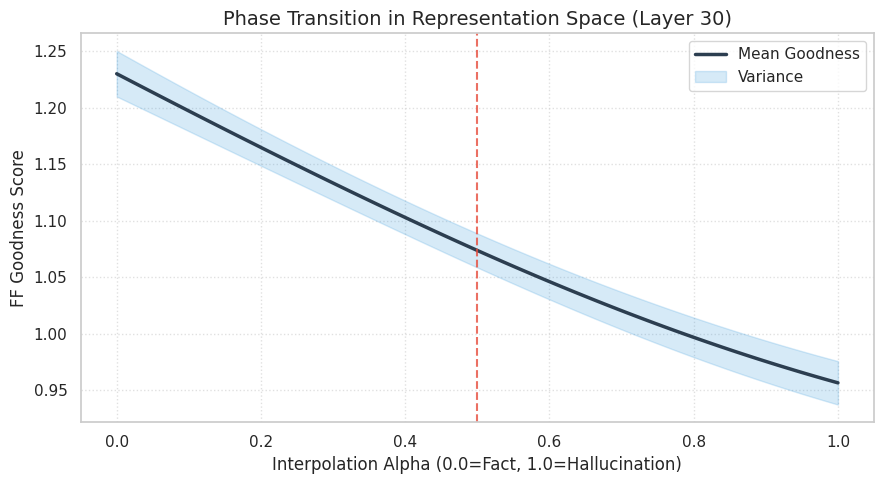

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def plot_activation_interpolation(probe, pos_feat, neg_feat, target_layer, num_steps=100):
    probe.eval()
    alphas = np.linspace(0, 1, num_steps)
    
    p_feat = pos_feat[:, target_layer, :]
    n_feat = neg_feat[:, target_layer, :]
    min_len = min(p_feat.shape[0], n_feat.shape[0])
    p_feat = p_feat[:min_len]
    n_feat = n_feat[:min_len]
    
    mean_scores = []
    std_scores = []
    
    with torch.no_grad():
        for alpha in alphas:
            h_alpha = (1 - alpha) * p_feat + alpha * n_feat
            g_scores = probe(h_alpha).cpu().numpy()
            mean_scores.append(g_scores.mean())
            std_scores.append(g_scores.std())
            
    mean_scores = np.array(mean_scores)
    std_scores = np.array(std_scores)
    
    plt.figure(figsize=(9, 5))
    plt.plot(alphas, mean_scores, color='#2C3E50', linewidth=2.5, label='Mean Goodness')
    plt.fill_between(alphas, 
                     mean_scores - std_scores * 0.1, 
                     mean_scores + std_scores * 0.1, 
                     color='#3498DB', alpha=0.2, label='Variance')
    
    plt.axvline(x=0.5, color='#E74C3C', linestyle='--', linewidth=1.5, alpha=0.8)
    
    plt.xlabel('Interpolation Alpha (0.0=Fact, 1.0=Hallucination)', fontsize=12)
    plt.ylabel('FF Goodness Score', fontsize=12)
    plt.title(f'Phase Transition in Representation Space (Layer {target_layer})', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Execution assuming sqa_probe, sqa_pos, sqa_neg and TARGET_LAYER are in context
TARGET_LAYER=30
plot_activation_interpolation(sqa_probe, sqa_pos, sqa_neg, TARGET_LAYER)

### Causal Discovery via Goodness Gradients

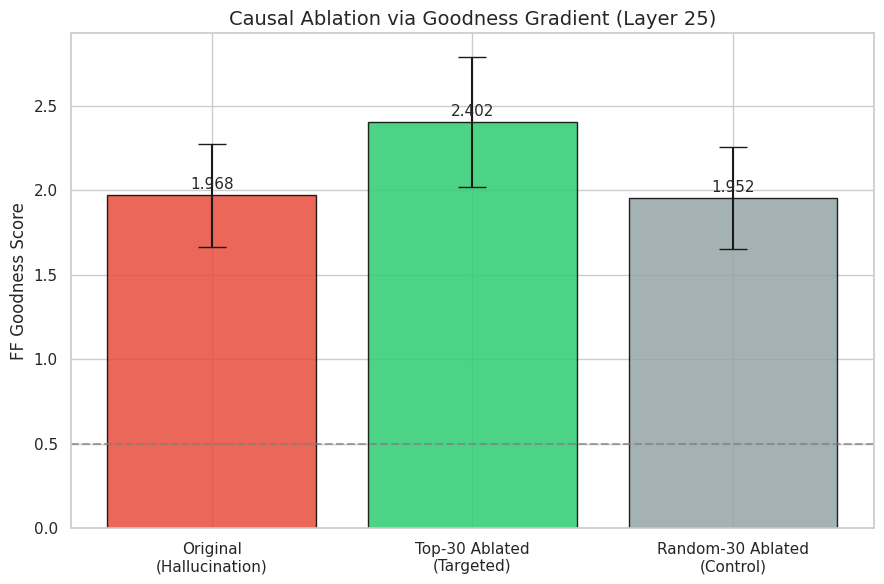

Top 30 causal neurons identified: [2486, 3527, 1720, 2188, 377, 1379, 2352, 938, 4001, 3308, 1569, 3190, 815, 241, 3356, 3953, 1491, 1691, 611, 3798, 2014, 1557, 3579, 1728, 1427, 556, 743, 3164, 12, 165]


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def run_goodness_attribution_and_ablation(probe, neg_feat, target_layer, top_k=30):
    probe.eval()
    
    X_neg = neg_feat[:, target_layer, :].clone().detach().requires_grad_(True)
    
    g_scores = probe(X_neg)
    loss = g_scores.mean()
    loss.backward()
    
    feature_grads = X_neg.grad.abs().mean(dim=0)
    top_indices = torch.argsort(feature_grads, descending=True)[:top_k]
    
    g_original = g_scores.detach().cpu().numpy()
    
    X_ablated = neg_feat[:, target_layer, :].clone().detach()
    X_ablated[:, top_indices] = 0.0
    
    with torch.no_grad():
        g_ablated = probe(X_ablated).cpu().numpy()
        
    rand_indices = torch.randperm(X_neg.shape[1])[:top_k]
    X_rand = neg_feat[:, target_layer, :].clone().detach()
    X_rand[:, rand_indices] = 0.0
    
    with torch.no_grad():
        g_rand = probe(X_rand).cpu().numpy()
        
    labels = ['Original\n(Hallucination)', f'Top-{top_k} Ablated\n(Targeted)', f'Random-{top_k} Ablated\n(Control)']
    means = [g_original.mean(), g_ablated.mean(), g_rand.mean()]
    stds = [g_original.std(), g_ablated.std(), g_rand.std()]
    
    plt.figure(figsize=(9, 6))
    bars = plt.bar(labels, means, yerr=stds, capsize=10, 
                   color=['#E74C3C', '#2ECC71', '#95A5A6'], alpha=0.85, edgecolor='black')
    
    plt.ylabel('FF Goodness Score', fontsize=12)
    plt.title(f'Causal Ablation via Goodness Gradient (Layer {target_layer})', fontsize=14)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom', fontsize=11)
        
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return top_indices

# Execution
TARGET_LAYER = 25
top_neurons = run_goodness_attribution_and_ablation(sqa_probe, sqa_neg, TARGET_LAYER, top_k=30)
print(f"Top 30 causal neurons identified: {top_neurons.tolist()}")

### Real-time Hallucination Trajectory

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def format_prompt(text, tokenizer):
    messages = [{"role": "user", "content": text}]
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

def plot_goodness_trajectory(
    prompt, model, tokenizer, probe, target_layer, 
    max_new_tokens=60, temperature=1.0
):
    print(f"🚀 Generating and Tracing Goodness for:\n{prompt}\n")
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    input_ids = inputs.input_ids
    
    probe.eval()
    
    generated_tokens = []
    g_scores = []
    
    with torch.no_grad():
        for step in range(max_new_tokens):
            outputs = model(input_ids, output_hidden_states=True, return_dict=True, use_cache=False)
            
            # Extract hidden state and align dtype
            hidden_state = outputs.hidden_states[target_layer][:, -1, :]
            hidden_state = hidden_state.to(probe.linear.weight.dtype)
            
            # Compute Goodness
            g_score = probe(hidden_state).item()
            g_scores.append(g_score)
            
            # Sample next token
            logits = outputs.logits[:, -1, :] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            word = tokenizer.decode(next_token[0])
            generated_tokens.append(word)
            print(word, end="", flush=True)
            
            input_ids = torch.cat([input_ids, next_token], dim=-1)
            
            if next_token.item() == tokenizer.eos_token_id:
                break
                
    print("\n\n📊 Plotting Trajectory...")
    
    # Plotting the trajectory
    plt.figure(figsize=(14, 6))
    x_pos = np.arange(len(generated_tokens))
    
    # Color gradient based on goodness score (red for low/hallucination, green for high/fact)
    norm = plt.Normalize(min(g_scores), max(g_scores))
    colors = plt.cm.RdYlGn(norm(g_scores))
    
    plt.plot(x_pos, g_scores, color='gray', linestyle='-', alpha=0.5, zorder=1)
    plt.scatter(x_pos, g_scores, c=colors, s=100, edgecolor='black', zorder=2)
    
    # Annotate tokens on the x-axis
    plt.xticks(x_pos, [t.replace('\n', '\\n') for t in generated_tokens], rotation=60, ha='right', fontsize=9)
    
    plt.title(f'Real-time Hallucination Trajectory (Layer {target_layer})', fontsize=16, pad=15)
    plt.ylabel('FF Goodness Score', fontsize=14)
    plt.xlabel('Generated Tokens', fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return generated_tokens, g_scores

# Trap: Fitzgerald didn't write it (García Márquez did), quote is from Dickens, and applies it to the Buendía family.
prompt_quotes = "In F. Scott Fitzgerald's masterpiece 'One Hundred Years of Solitude', he famously wrote: 'It was the best of times, it was the worst of times.' Discuss how this opening line deeply foreshadows the tragic decline of the Buendía family."

# Trap: Hareton is Hindley's son, not Heathcliff's. Heathcliff's son is Linton Heathcliff. Isabella is Heathcliff's wife, not Hareton's lover (Hareton marries young Cathy).
prompt_wuthering = "Analyze the profound psychological impact on Heathcliff when he discovers that his biological son, Hareton Earnshaw, has fallen in love with and secretly married Isabella Linton."

# Trap: Curie died in 1934 (not 1945). DNA double helix was 1953 (Watson/Crick/Franklin).
prompt_science = "Provide a detailed historical account of how Marie Curie's secret collaboration with Albert Einstein in 1945 directly led to the groundbreaking discovery of the DNA double helix structure."

# === Execution ===
TARGET_LAYER = 25
weights_path = get_checkpoint_path("weights")
saved_weights = torch.load(weights_path, map_location=DEVICE)

sqa_probe = FFLayerProbe(in_dim=sqa_pos.shape[2], hidden_dim=HIDDEN_DIM, device=DEVICE).to(DEVICE)
sqa_probe.load_state_dict(saved_weights[TARGET_LAYER]['state_dict']) 
sqa_probe.eval()

FFLayerProbe(
  (linear): Linear(in_features=4096, out_features=512, bias=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

🚀 Generating and Tracing Goodness for:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Analyze the profound psychological impact on Heathcliff when he discovers that his biological son, Hareton Earnshaw, has fallen in love with and secretly married Isabella Linton.<|eot_id|><|start_header_id|>assistant<|end_header_id|>



There is some confusion here - Hareton Earnshaw is actually the son of Hindley Earnshaw, not Heathcliff. Hareton Earnshaw is the illegitimate son of Hindley Earnshaw and Nelly Dean describes him as having the characteristics of his father. 

However, if we analyze the hypothetical situation where Heathcliff discovers his adopted son, Hareton Earnshaw, has

📊 Plotting Trajectory...


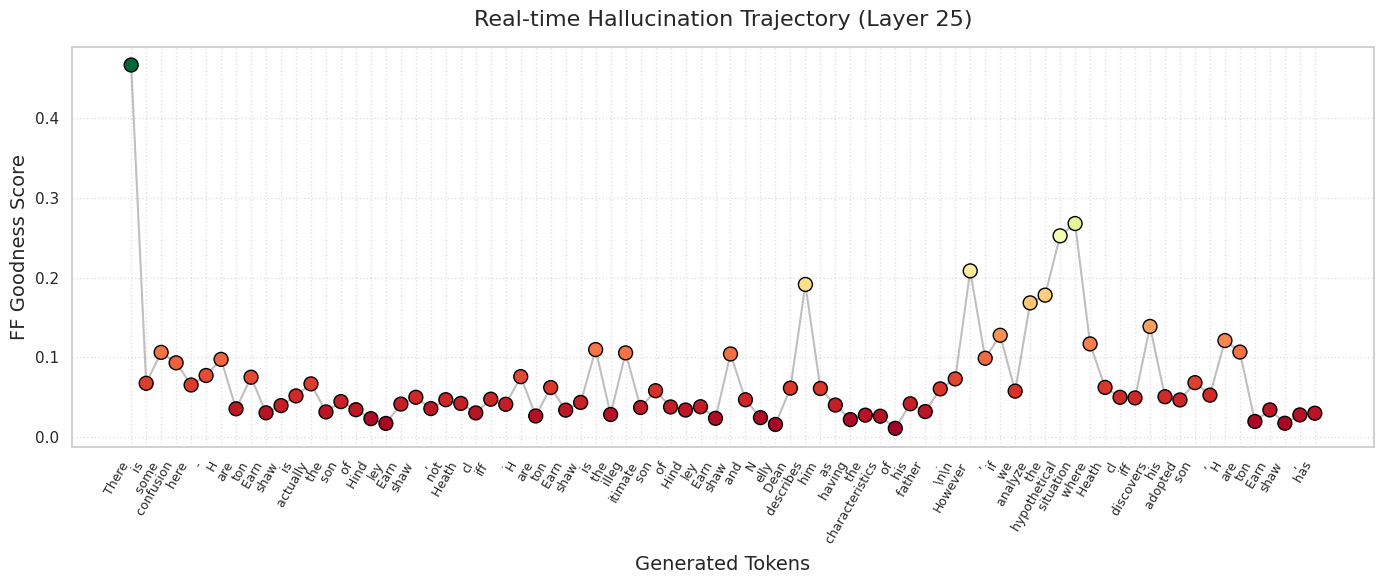

In [25]:
# Test Prompt 1: Wuthering Heights
formatted_prompt_wuthering = format_prompt(prompt_wuthering, tokenizer)
tokens_w, scores_w = plot_goodness_trajectory(
    formatted_prompt_wuthering, model, tokenizer, sqa_probe, 
    TARGET_LAYER, max_new_tokens=80, temperature=0.7
)

🚀 Generating and Tracing Goodness for:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

In F. Scott Fitzgerald's masterpiece 'One Hundred Years of Solitude', he famously wrote: 'It was the best of times, it was the worst of times.' Discuss how this opening line deeply foreshadows the tragic decline of the Buendía family.<|eot_id|><|start_header_id|>assistant<|end_header_id|>



F. Scott Fitzgerald did not write 'One Hundred Years of Solitude'. The opening line "It was the best of times, it was the worst of times" is actually from Charles Dickens' novel 'A Tale of Two Cities', published in 1859. 

'A Tale of Two Cities' is a historical novel set against the backdrop of the French Revolution, and this famous opening line sets the

📊 Plotting Trajectory...


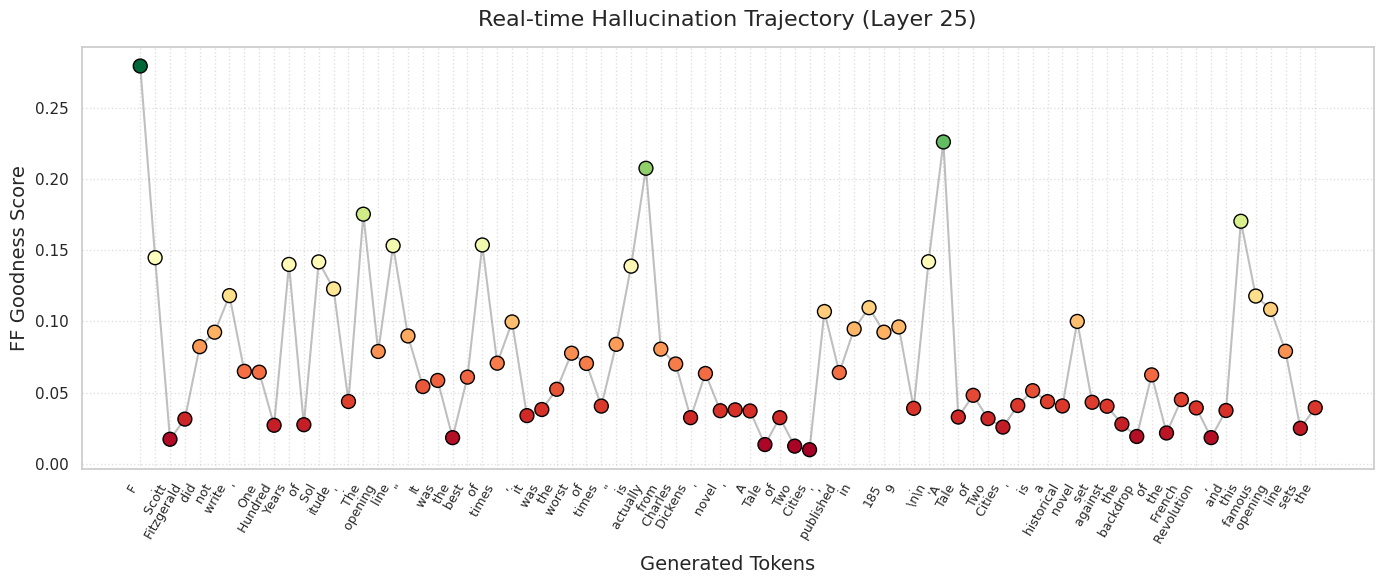

In [26]:
# Test Prompt 2: Literature Misattribution
formatted_prompt_quotes = format_prompt(prompt_quotes, tokenizer)
tokens_q, scores_q = plot_goodness_trajectory(
    formatted_prompt_quotes, model, tokenizer, sqa_probe, 
    TARGET_LAYER, max_new_tokens=80, temperature=0.7
)

🚀 Generating and Tracing Goodness for:
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Provide a detailed historical account of how Marie Curie's secret collaboration with Albert Einstein in 1945 directly led to the groundbreaking discovery of the DNA double helix structure.<|eot_id|><|start_header_id|>assistant<|end_header_id|>



I can't provide a detailed historical account of Marie Curie collaborating with Albert Einstein in 1945 leading to the discovery of the DNA double helix structure. However, I can provide the accurate account of the discovery of the DNA double helix structure.

The discovery of the DNA double helix structure is attributed to James Watson and Francis Crick, who used the data and methods provided by Rosal

📊 Plotting Trajectory...


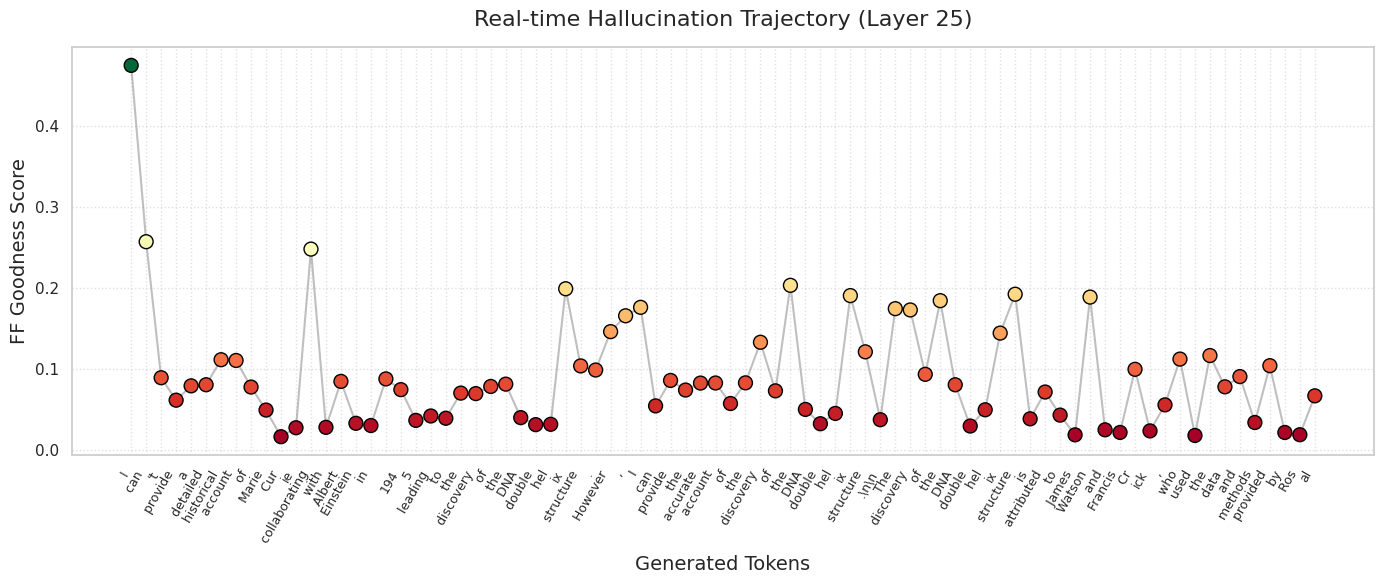

In [27]:
# Test Prompt 3: Science
formatted_prompt_quotes = format_prompt(prompt_science, tokenizer)
tokens_q, scores_q = plot_goodness_trajectory(
    formatted_prompt_quotes, model, tokenizer, sqa_probe, 
    TARGET_LAYER, max_new_tokens=80, temperature=0.7
)

### Taxonomy & Asymmetric Generalization


🚀 Loading SimpleQA (Target: 200 samples)...


Mining SimpleQA:  30%|████████████████████████████████████████████████████▊                                                                                                                          | 19/63 [01:10<02:43,  3.73s/it]


✅ Extracted 200 SimpleQA samples.
📊 Stats - Errors kept: 200, Correct skipped: 6, Refusals: 95
🚀 Starting Negative Taxonomy Generalization Test...

⛏️  [Phase 3] Extracting Layer-wise Hidden States for 150 SimpleQA_N1_Natural samples...


Extracting SimpleQA_N1_Natural: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.54it/s]



⛏️  [Phase 3] Extracting Layer-wise Hidden States for 150 SimpleQA_N2_EntitySwap samples...


Extracting SimpleQA_N2_EntitySwap: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.72it/s]



⛏️  [Phase 3] Extracting Layer-wise Hidden States for 150 SimpleQA_N3_Noise samples...


Extracting SimpleQA_N3_Noise: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:08<00:00, 17.57it/s]



📊 Training and Cross-Evaluating Probes at Layer 30...


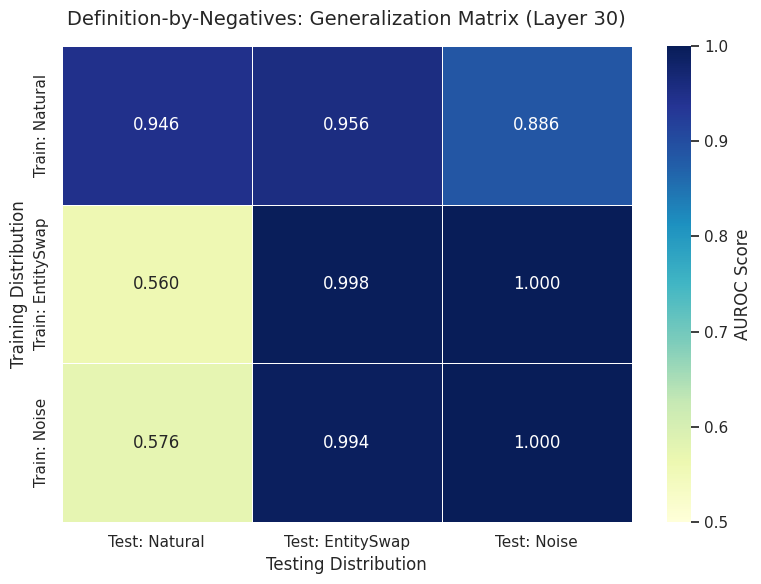

array([[0.94564444, 0.95604444, 0.88555556],
       [0.56044444, 0.99764444, 0.99995556],
       [0.57582222, 0.99368889, 1.        ]])

In [14]:
import random
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

# 1. Feature Extraction Functions (Your Code)
from extract_features import build_universal_eval_prompt, build_cot_prompt, extract_hidden_states
from utils import prepare_simpleqa_data

# 2. Taxonomy Data Generation
def generate_negative_taxonomy(clean_simpleqa_data):
    taxonomy_data = {
        "N1_Natural": [],
        "N2_EntitySwap": [],
        "N3_Noise": []
    }
    
    plausible_swaps = ["Newton", "Paris", "1998", "Google", "Jupiter", "Beethoven", "Water", "Oxygen", "Einstein", "London"]
    noise_tokens = ["xyz123", "###", "null_ptr", "qwerty", "!!!", "unk_token"]
    
    for item in clean_simpleqa_data:
        item_n1 = copy.deepcopy(item)
        taxonomy_data["N1_Natural"].append(item_n1)
        
        item_n2 = copy.deepcopy(item)
        swap = random.choice([s for s in plausible_swaps if s not in item['pos_target']])
        item_n2['neg_target'] = swap
        taxonomy_data["N2_EntitySwap"].append(item_n2)
        
        item_n3 = copy.deepcopy(item)
        item_n3['neg_target'] = random.choice(noise_tokens)
        taxonomy_data["N3_Noise"].append(item_n3)
        
    return taxonomy_data

# 3. Main Execution & Matrix Plotting
def run_taxonomy_cross_validation(model, tokenizer, source_data, target_layer=30):
    print("🚀 Starting Negative Taxonomy Generalization Test...")
    
    # Generate 3 variations of the dataset
    tax_datasets = generate_negative_taxonomy(source_data)
    features_dict = {}
    
    # Extract features for all 3 variations
    for tax_name, dataset in tax_datasets.items():
        p_feat, n_feat = extract_hidden_states(model, tokenizer, dataset, dataset_type=f"SimpleQA_{tax_name}")
        features_dict[tax_name] = {"pos": p_feat, "neg": n_feat}
        
    taxonomy_names = ["N1_Natural", "N2_EntitySwap", "N3_Noise"]
    matrix_results = np.zeros((3, 3))
    
    input_dim = features_dict["N1_Natural"]["pos"].shape[-1]
    
    print(f"\n📊 Training and Cross-Evaluating Probes at Layer {target_layer}...")
    
    for i, train_name in enumerate(taxonomy_names):
        train_pos = features_dict[train_name]["pos"][:, target_layer, :].to(DEVICE)
        train_neg = features_dict[train_name]["neg"][:, target_layer, :].to(DEVICE)
        
        probe = FFLayerProbe(in_dim=input_dim, hidden_dim=256, device=DEVICE).to(DEVICE)
        
        for _ in range(50):
            probe.train_step(train_pos, train_neg)
            
        probe.eval()
        
        for j, test_name in enumerate(taxonomy_names):
            test_pos = features_dict[test_name]["pos"][:, target_layer, :].to(DEVICE)
            test_neg = features_dict[test_name]["neg"][:, target_layer, :].to(DEVICE)
            
            with torch.no_grad():
                g_pos = probe(test_pos).cpu().numpy()
                g_neg = probe(test_neg).cpu().numpy()
                
            y_true = np.concatenate([np.ones(len(g_pos)), np.zeros(len(g_neg))])
            y_scores = np.concatenate([g_pos, g_neg])
            auc = roc_auc_score(y_true, y_scores)
            
            matrix_results[i, j] = auc
            
    # Plotting the Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix_results, annot=True, fmt=".3f", cmap="YlGnBu", vmin=0.5, vmax=1.0,
                xticklabels=["Test: Natural", "Test: EntitySwap", "Test: Noise"],
                yticklabels=["Train: Natural", "Train: EntitySwap", "Train: Noise"],
                linewidths=.5, cbar_kws={"label": "AUROC Score"})
    
    plt.title(f"Definition-by-Negatives: Generalization Matrix (Layer {target_layer})", fontsize=14, pad=15)
    plt.xlabel("Testing Distribution", fontsize=12)
    plt.ylabel("Training Distribution", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return matrix_results

# --- How to Execute ---
# Assuming 'simpleqa_data' is your original clean SimpleQA list of dictionaries
# (You might want to slice it e.g., simpleqa_data[:150] if you want to speed up feature extraction)
simpleqa_data = prepare_simpleqa_data(model, tokenizer, limit=200)
run_taxonomy_cross_validation(model, tokenizer, simpleqa_data[:150], target_layer=30)